### Data

In [70]:
import pandas as pd
import numpy as np

data = pd.read_csv("./bml-component-data.csv")

# Scale time column
data["timestamp"] /= 10000
data = data.drop(columns=["index"])

In [71]:
def pad(array, target_length):
    """Pads 1D array to target length using -1 constant as padding."""

    n_pad = target_length - array.shape[0]
    return np.pad(array, (0, n_pad), mode="constant", constant_values=[-1])

In [72]:
# Collect all values from each CX into one row and put timestamps and efficiencies into np arrays
data_grouped = data.groupby(["ID"]).agg(list)
data_grouped = data_grouped.map(np.array)

# Each row is exactly one CX
x = list(data_grouped["timestamp"])
y = list(data_grouped["efficiency"])

# Rows are ragged (rows aren't all the same length) so padding is required
max_obs = max([len(row) for row in y])

x_padded = np.array([pad(row, max_obs) for row in x])
y_padded = np.array([pad(row, max_obs) for row in y])

# Generate mask (True for actual values, False for padded values)
mask = x_padded != -1

In [73]:
# Generate M1 to M5 arrays. Each M value is the same for all measurements within a CX component
M_df = data.drop_duplicates(subset=["ID"])

# M[0] is all M1 values, M[1] is all M2 values etc.
M = np.array([M_df["M1"], M_df["M2"], M_df["M3"], M_df["M4"], M_df["M5"]])
M

array([[ 0.585,  2.449,  0.368,  3.033,  0.244,  0.086,  1.301,  0.346,
         2.101,  0.457,  3.035,  2.226,  0.579,  2.382,  0.561,  0.542,
         0.169,  1.066,  0.319,  0.234,  0.293,  2.471,  6.549,  2.086,
         0.848,  0.854,  0.546,  0.214,  1.083,  4.228,  0.522,  2.357,
         7.419,  4.763,  1.007,  1.289,  0.796,  0.278,  0.421,  1.166,
         0.264,  4.304,  0.136,  0.525,  1.365,  1.207,  2.199,  0.473,
         0.82 ,  1.026,  0.481,  0.152,  0.459,  0.138,  4.419,  0.39 ,
         0.724,  0.569,  2.099,  0.307,  0.245,  1.264,  1.52 ,  3.978,
         0.621,  0.929,  0.543,  0.433,  7.622,  0.558,  0.826,  0.703,
         1.133,  0.65 ,  3.052],
       [ 1.788,  0.708,  0.286,  1.183,  2.16 , 22.199,  0.457,  1.768,
         0.253,  0.832,  0.411,  1.275,  3.525,  0.418,  0.416,  0.682,
         0.691,  3.434,  1.821,  1.079,  0.467,  1.919,  1.668,  0.566,
         0.377,  1.927,  3.035,  0.658, 14.269,  0.591,  5.092,  0.301,
         0.531,  1.136,  0.423,

### Enhanced Model

Model the efficiency $y_i$ as a noisy exponential decay function $f_i$, with parameters $u_i$, $v_i$ and $w_i$:

$$y_i(t) = f_i(t) + \epsilon$$

$$f_i(t) = u_i \cdot \exp \left \{-\left (v_i + \sum \limits _{j=1} ^5 w_j m_{ji}\right ) t \right \}$$

We omit the 10,000 divisor since we already divided the timestamp earlier.

In [74]:
import numpyro as npr
import numpyro.distributions as dist
import jax.numpy as jnp

def model(t, y, m, mask):
    sigma = npr.sample("sigma", dist.HalfNormal(1))

    # Generate u_i and v_i for all CX components
    with npr.plate("cx-component", t.shape[0]):
        u = npr.sample("u", dist.Normal(90, 10))
        v = npr.sample("v", dist.Normal(5, 5))

    # Generate a weight for each M component
    with npr.plate("m", m.shape[0]):
        w = npr.sample("w", dist.Normal(0, 1))

    # Make predictions of f_i(t) then sample from normal dist with variance sigma to account for noise
    with npr.plate("observations", t.shape[1]):
        with npr.handlers.mask(mask=mask):
            m_sum = -(v + jnp.matmul(w, m))
            f = u[:, jnp.newaxis] * jnp.exp(m_sum[:, jnp.newaxis] * t)
            npr.sample("obs", dist.Normal(f, sigma), y)

In [75]:
from jax import random
from numpyro.infer import MCMC, NUTS

seed = 1
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(seed)
mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
mcmc.print_summary()

C:\Users\jayde\AppData\Local\Temp\ipykernel_404\584995192.py:8: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
sample: 100%|██████████| 1500/1500 [00:10<00:00, 138.45it/s, 255 steps of size 1.99e-02. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.07      0.13      5.08      4.87      5.29   1507.42      1.00
      u[0]     91.90      2.45     91.81     87.86     95.79   2834.64      1.00
      u[1]     91.78      2.55     91.74     87.40     95.59   2158.11      1.00
      u[2]     92.73      2.80     92.70     88.25     97.32   2831.82      1.00
      u[3]     91.14      4.25     91.13     83.51     97.53   3361.06      1.00
      u[4]     88.71      4.61     88.64     81.12     95.57   1717.82      1.00
      u[5]     96.64      6.16     96.81     87.54    107.38   2812.85      1.00
      u[6]     91.17      5.09     91.13     83.42     99.70   3074.76      1.00
      u[7]     90.68      4.50     90.44     83.57     98.41   2547.42      1.00
      u[8]    102.57      3.94    102.58     96.40    108.99   2840.36      1.00
      u[9]     89.01      4.61     88.98     81.87     97.14   2847.18      1.00
     u[10]    100.01      2

In [76]:
samples = mcmc.get_samples()

jnp.abs(samples["v"]).mean()

Array(4.373591, dtype=float32)

### Visualisation

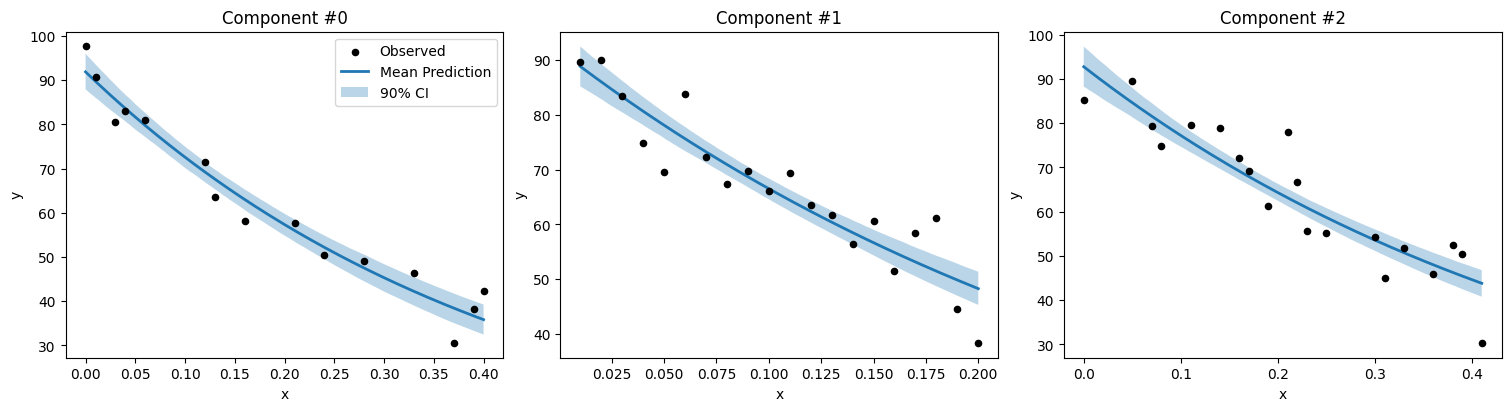

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

def plot_component_fits(mcmc, x_data, y_data, mask, M, num_plots=6):
    """
    Plots observed data vs inferred decay curves with 90% CI,
    using the full model with M and w weights.
    """
    samples = mcmc.get_samples()
    u = samples['u']        # (num_samples, N)
    v = samples['v']        # (num_samples, N)
    w = samples['w']        # (num_samples, K)  K = features in M

    # Compute full m_sum for each sample and component: -(v_i + w·M_i)
    # w: (num_samples, K), M: (N, K) → (num_samples, N)
    m_effect = np.dot(w, M)         # (num_samples, N)
    m_sum = -(v + m_effect)           # (num_samples, N)

    cols = 3
    rows = (num_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
    axes = axes.flatten()

    indices_to_plot = np.arange(min(num_plots, x_data.shape[0]))

    for i, ax in zip(indices_to_plot, axes):

        valid_idx = mask[i].astype(bool)
        x_real = x_data[i][valid_idx]
        y_real = y_data[i][valid_idx]

        sort_order = np.argsort(x_real)
        x_real = x_real[sort_order]
        y_real = y_real[sort_order]

        x_smooth = jnp.linspace(x_real.min(), x_real.max(), 200)

        # Extract posterior samples for this component
        u_i = u[:, i]                # (samples,)
        m_i = m_sum[:, i]            # (samples,)

        # Compute predictions: u_i * exp(m_i * x)
        predictions = u_i[:, None] * jnp.exp(m_i[:, None] * x_smooth)

        mean_pred = jnp.mean(predictions, axis=0)
        hpdi_low = jnp.percentile(predictions, 5, axis=0)
        hpdi_high = jnp.percentile(predictions, 95, axis=0)

        ax.scatter(x_real, y_real, color='black', s=20, label='Observed', zorder=3)
        ax.plot(x_smooth, mean_pred, lw=2, label='Mean Prediction')
        ax.fill_between(x_smooth, hpdi_low, hpdi_high, alpha=0.3, label='90% CI')

        ax.set_title(f"Component #{i}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        if i == 0:
            ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

plot_component_fits(mcmc, x_padded, y_padded, mask, M=M, num_plots=3)

### Blind Predictions

Predict probability over all 1000 samples and average.



In [78]:
import jax.scipy.stats as stats

def predict_probability_below(samples, component: int, m: np.array, t: float = 40.0, y: float = 35.0):
    """
    Returns predicted probability of a component being below
    efficiency `y` at time `t`.
    """
    t /= 10_000
    prob = 0

    # Get the component's M1 to M5 values
    m_component = m[:, component]

    # Iterate over all samples and calculate probability for each
    for sample in zip(samples["sigma"], samples["u"], samples["v"], samples["w"]):
        s = sample[0]
        u = sample[1][component]
        v = sample[2][component]
        w = sample[3]

        m_sum = -(v + jnp.matmul(w, m_component))
        f = u * jnp.exp(m_sum * t)
        prob += stats.norm.cdf(y, loc=f, scale=s)
    
    return prob / len(samples["sigma"])


predict_probability_below(samples, component=0, m=M)

Array(1.6775193e-22, dtype=float32)